# A picture spoken by 500 words, according to CNN - Part 2 
Eu Jin Lok

9 February 2018

# Word Embedding using GloVe
In this notebook we will go into the details of how to build a document classifier using CNN, a deep learning architecture well known for images classification. For the full background on this topic, please checkout my blog post in this link: 

https://mungingdata.wordpress.com/2018/02/24/episode-4-a-picture-spoken-by-500-words-according-to-cnn/

This is part 2 of the code which looks at creating a Word Embedding using pretrained GloVe vectors. The word embedding will serve as weighting scheme for the embedding layer of our CNN model. More specifically, we will use the 100-dimensional GloVe embeddings of 400k words trained on 2014 dump of English Wikipedia. More information about GloVe vectors and to get the dataset:

https://nlp.stanford.edu/projects/glove/
 
So without further ado, lets begin....

In [38]:
#import the key libraries 
import pandas as pd 
import numpy as np
import os 
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
import pickle
os.chdir("C:\\Users\\User\\Dropbox\\Pet Project\\Blog\\CNN\\")

So first step after loadings the necessary packages, we'll go grab our training dataset again and run through the same data processing. We need the vocabulary set so we can do a vocabulary-lookup to the GloVe vectors

In [39]:
# import data 
train = pd.read_csv("happydb\\cleaned_hm.csv")  

# Lets one-hot encode the labels  
labels=train.predicted_category.unique()
dic={}
for i,labels in enumerate(labels):
    dic[labels]=i
labels=train.predicted_category.apply(lambda x:dic[x])

val=train.sample(frac=0.2,random_state=200)
train=train.drop(val.index)

This bit below is an important one. We are essentially creating a vocabulary list of key words, and the object is needed for the word embedding processing... 

In [48]:
NUM_WORDS=20000 # if set, tokenization will be restricted to the top num_words most common words in the dataset).
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

# we need to fit the tokenizer on our text data in order to get the tokens
texts=train.cleaned_hm
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens or words.' % len(word_index)) 

Found 23313 unique tokens or words.


# Create Word Embedding
We will be using a pretrained embeddings of 100-dimensional GloVe embeddings of 400k words. See above to get the link to the dataset. The process is essentially, do a lookup of our current vocabulary with the GloVe embedding, and retrieve all the 100 Dimensions. 

In [49]:
# Lets pull out the core elements in the GloVe dataset, ie. the Weights x Dimensions, and words 
embeddings_index = dict()
f = open('C:\\Users\\User\\Documents\\GIT\\170411 Deep Learning NLP personal\\glove.6B\\glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index)) #400k words
print(len(coefs), "dimensions or vectors")

Loaded 400000 word vectors.
100 dimensions or vectors


Now, the 'tokenizer' object that we create above, is needed here below. For all our vocabulary as stored in 'tokenizer', we'll get the 100 dimension matrix from GloVe

In [50]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape, "= embedding matrix dimension")

(23314, 100) = embedding matrix dimension


So now that we have the embedding values / weights for our vocabularity set, we can save it, using pickle. We will be using this as the weights for the embedding layer in CNN. And that is all we need from this script here. 

In [ ]:
pickle_out = open("C:\\Users\\User\\Downloads\\dump\\embedding matrix.pickle","wb")
pickle.dump(embedding_matrix, pickle_out)
pickle_out.close()

Lets do some visualisation to ensure we still haven't lost the plot yet. WARNING this T-SNE plot takes a while to run. This part is optional so just skip it if you aren't interested: 

In [56]:
import sklearn.manifold #Tsne plot 
import matplotlib.pyplot as plt
import seaborn as sns

# Just one function to create the plot 
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=10)

# Careful now this bit takes awhile.
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix_2d = tsne.fit_transform(embedding_matrix)

points = list(word_index.items())
points = pd.DataFrame(points)
points = pd.concat([points, pd.DataFrame(all_word_vectors_matrix_2d)], axis=1)
points.columns = ['word','index','x','y']
points = points.drop(['index'], axis=1)
points.head(10)

,word,x,y
0,jumps,4.456871,2.163164
1,terrified,-4.147264,-1.070810
2,myx,-4.189087,-1.100443
3,tank,-4.219866,-2.230031
4,birch,-3.952755,-2.330288
5,kilometers,-4.117298,-2.282881
6,aren,-4.138616,-2.298080
7,jayalalitha,-4.124540,-2.329947
8,bestbuy,-4.126612,-2.311629
9,sexytimes,-4.223188,-2.238296


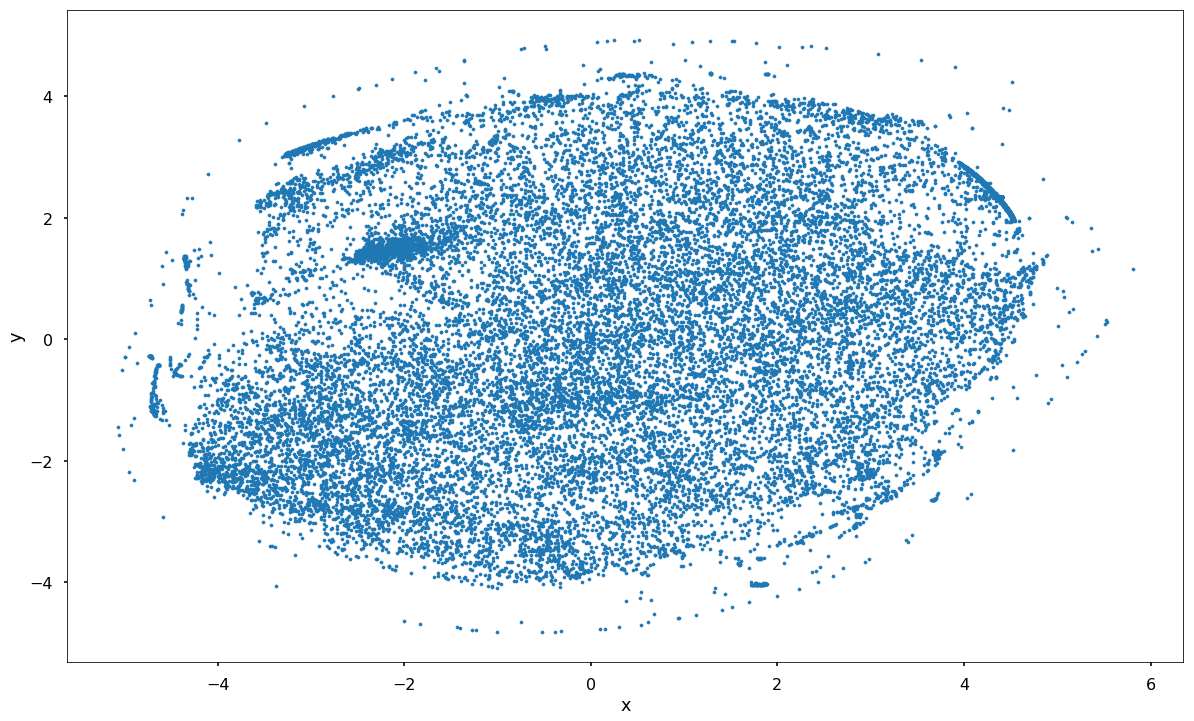

In [54]:
# The big picture
%matplotlib inline
sns.set_context("poster")    
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

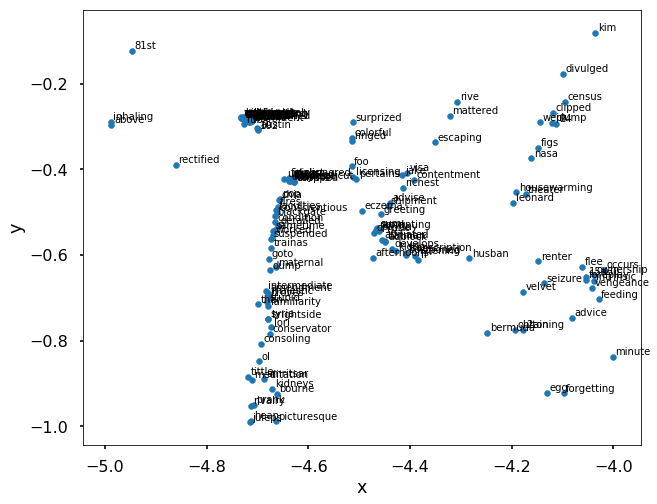

In [55]:
# Check the long strip on the far left middle bit
plot_region(x_bounds=(-5, -4), y_bounds=(-1, 0))